<div style="margin: 20px; text-align: center; font-size: 30px;"> Cyfrowe Przetwarzanie Obrazów</div>
<div style="margin: 20px; text-align: center; font-size: 30px;">Projekt aplikacji rozpoznającej logo marki Shell ze zdjęć</div>
<br><br>
<div style="margin: 10px; text-align: right; font-size: 20px;"> Opracował: Maciej Pęśko</div>
<div style="margin: 10px; text-align: right; font-size: 20px;"> Prowadzący: dr inż. Tomasz Trzciński</div>


### INSTRUCTION
#### 1. TO EVALUATE RESULTS RUN WHOLE NOTEBOOK HAVING:
 - 'test_dataset.data' and 'train_and_validation_dataset.data' in 'data' directory
 - 'evaluation' directory with test images called '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg'
 - 'data/logo_64/logo0.jpg' first version of logo
 
 All above data available here:
 https://github.com/maciej3031/shell_logo_detection/tree/master/data
 
#### 2. NOTEBOOK WITH RESULTS AVAILABLE HERE: https://github.com/maciej3031/shell_logo_detection/blob/master/shell_logo_detection.ipynb

In [67]:
import os
import pickle
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

random.seed()

In [68]:
def jj(*args):
    return os.path.join(*args)

LOGO = jj('data','logo')
OTHER = jj('data','other')
LOGO_64 = jj('data','logo_64')
OTHER_64 = jj('data','other_64')

# IMAGE SIZE USED FOR SVM LEARNING
IMG_SIZE = 64

# NUMBER OF IMAGES FOR SVM LEARNING
NUMBER_OF_LOGOS = 7500
NUMBER_OF_OTHERS = 7500

#### FUNCTION FOR LOADING SAVED DATASETS.

In [69]:
# Load train_and_validation dataset
train_and_validation = pickle.load(open(os.path.join("data", "train_and_validation_dataset.data"), "rb" ))
test = pickle.load(open(os.path.join("data", "test_dataset.data"), "rb" ))

## 1. COMPUTER VISION UTILS

#### SOME UTILS USED TO WORK WITH IMAGES.

In [70]:
def open_image(full_image_name, color=True):
    if color:
        return cv2.imread(full_image_name, 3)
    else:
        return cv2.imread(full_image_name, 0)
    
def resize(img, n, m):
    return cv2.resize(img, (n, m))

def resize_image_to_nxn_square(img, n):
    longer_side = max(img.shape)
    horizontal_padding = int((longer_side - img.shape[0]) / 2)
    vertical_padding = int((longer_side - img.shape[1]) / 2)
    
    new_image = cv2.copyMakeBorder(img,
                                   horizontal_padding,
                                   horizontal_padding,
                                   vertical_padding,
                                   vertical_padding,
                                   cv2.BORDER_REPLICATE)    
    resized_img = resize(new_image, n, n)
    return resized_img

def normalize(dataset):
    max_val = np.max(dataset)
    min_val = np.min(dataset)
    if max_val == min_val:
        max_val += 0.000001
    return (dataset-min_val)/(max_val - min_val)


def hitogram_equalization(im):
    histogram = [0.0] * 256
    h, w = im.shape
    for i in range(h):
        for j in range(w):
            histogram[im[i, j]] += 1
    normalized_histogram = np.array(histogram)/(h*w)
    cumulative_historgam = np.array([sum(normalized_histogram[:i+1]) for i in range(len(normalized_histogram))])
    
    new_value = np.uint8(255 * cumulative_historgam)
    new_image = np.zeros(im.shape, dtype=np.uint8)
    
    for i in range(h):
        for j in range(w):
            new_image[i, j] = new_value[im[i, j]]

    return new_image

def rotate(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
 
    M[0, 2] += (w / 2) - cX
    M[1, 2] += (h / 2) - cY
 
    return cv2.warpAffine(image, M, (w, h))

def generate_logos():
    for i in tqdm(range(1, NUMBER_OF_LOGOS)):
        angle = random.randint(-20,21)
        padding = random.randint(0,15)

        img = open_image(jj(LOGO, 'logo0.jpg'))

        img = cv2.copyMakeBorder(img,
                                   padding,
                                   padding,
                                   padding,
                                   padding,
                                   cv2.BORDER_CONSTANT) 
        resize_image_to_nxn_square(img, 64)
        rows,cols,ch = img.shape

        pts1 = np.float32([[10,10],[10,90],[90,10]])
        pts2 = np.float32([[random.randint(7,13), random.randint(7,13)],
                           [random.randint(7,13),random.randint(87,93)],
                           [random.randint(87,93),random.randint(7,13)]])

        M = cv2.getAffineTransform(pts1,pts2)

        img = cv2.warpAffine(img,M,(cols,rows))  

        img = rotate(img, angle)
        cv2.imwrite(jj(LOGO, 'logo{}.jpg'.format(i)), img)  

## 2. MACHINE LEARNING UTILS

#### SOME MACHINE LEARNING UTILS USED FOR SVM LEARNING AND EVALUATION. 

In [71]:
def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]

def split_data(dataset, train_size=0.8):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
        size = dataset.shape[0]
    elif isinstance(dataset, list):
        random.shuffle(dataset)
        size=len(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Python List required.')
    
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]

def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    elif isinstance(dataset, list):
        random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Python List required.')

    return np.array_split(dataset, k)

def plot_confusion_matrix(model, x, y):
    predicted = svm.predict(x)[1]
    actual = y.reshape(-1,1)

    TP = np.count_nonzero(predicted * actual)
    TN = np.count_nonzero((predicted - 1) * (actual - 1))
    FP = np.count_nonzero(predicted * (actual - 1))
    FN = np.count_nonzero((predicted - 1) * actual)

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns =['actual 1', 'actual 0'], index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print("\n")
    print(confusion_matrix)
    
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b', linewidth=7.0)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## 3. IMPLEMENTED ALGORITHMS

## 3.1 CANNY ALGORITHM

#### FIRST TRY TO GET FEATURES - OBTAIN EDGES USING CANNY ALGORITHM. UNFORTUNATELY NO GOOD RESULTS WITH THIS APPROACH.

In [72]:
class Canny(object):
    def __init__(self, img, minVal, maxVal):
        self.minVal = minVal
        self.maxVal = maxVal
        self.gaussian_filter = np.asarray([[1, 4, 7, 4, 1],
                                           [4, 16, 26, 16, 4],
                                           [7, 26, 41, 26, 7],
                                           [4, 16, 26, 16, 4],
                                           [1, 4, 7, 4, 1]], dtype=np.int)

        self.sobel_Gx_filter = np.asarray([[-1, 0, 1],
                                           [-2, 0, 2],
                                           [-1, 0, 1]], dtype=np.int)

        self.sobel_Gy_filter = np.asarray([[-1, -2, -1],
                                           [0, 0, 0],
                                           [1, 2, 1]], dtype=np.int)

        self.array = np.asarray(img, dtype=np.int)
        self.height, self.width = self.array.shape[0], self.array.shape[1]
        self.canny_edges = np.zeros(self.array.shape)

        self.run()

    def run(self):
        array_after_gaussian_filtering = self.get_gaussian_filtered_array()
        array_after_Gx = self.get_array_after_Gx(array_after_gaussian_filtering)
        array_after_Gy = self.get_array_after_Gy(array_after_gaussian_filtering)
        array_G = self.get_array_after_G(array_after_Gx, array_after_Gy)
        array_theta = self.get_array_after_theta(array_after_Gx, array_after_Gy)
        array_nmax_suppress = self.get_array_after_suppression(array_G, array_theta)

        self.set_array_after_thresholding(array_nmax_suppress)

    def get_features(self):
        return self.canny_edges

    def get_gaussian_filtered_array(self):
        zero_padded_array = np.pad(self.array, 2, mode='constant')
        array_after_gaussian_filtering = self.convolve(zero_padded_array, self.gaussian_filter)
        return array_after_gaussian_filtering // 273

    def get_array_after_Gx(self, array_after_gaussian_filtering):
        zero_padded_array = np.pad(array_after_gaussian_filtering, 1, mode='constant')
        return self.convolve(zero_padded_array, self.sobel_Gx_filter)

    def get_array_after_Gy(self, array_after_gaussian_filtering):
        zero_padded_array = np.pad(array_after_gaussian_filtering, 1, mode='constant')
        return self.convolve(zero_padded_array, self.sobel_Gy_filter)

    def get_array_after_G(self, array_after_Gx, array_after_Gy):
        return np.sqrt(np.square(array_after_Gx) + np.square(array_after_Gy))

    def get_array_after_theta(self, array_after_Gx, array_after_Gy):
        return np.arctan2(array_after_Gy, array_after_Gx) * 180 / np.pi

    def get_array_after_suppression(self, array_G, array_theta):
        array_nmax_suppress = np.zeros(self.array.shape)
        for row in range(self.height):
            for col in range(self.width):
                if self.width - 1 > col > 0 and self.height - 1 > row > 0:
                    # 0 degrees
                    if (22.5 > array_theta[row][col] >= -22.5) or (
                            array_theta[row][col] < -157.5 or array_theta[row][col] >= 157.5):
                        if array_G[row][col] >= array_G[row][col + 1] and array_G[row][col] >= \
                                array_G[row][col - 1]:
                            array_nmax_suppress[row][col] = array_G[row][col]

                    # 45 degrees
                    if (67.5 > array_theta[row][col] >= 22.5) or (-112.5 > array_theta[row][col] >= -157.5):
                        if array_G[row][col] >= array_G[row - 1][col - 1] and array_G[row][col] >= \
                                array_G[row + 1][col + 1]:
                            array_nmax_suppress[row][col] = array_G[row][col]

                    # 90 degrees
                    if (112.5 > array_theta[row][col] >= 67.5) or (-67.5 > array_theta[row][col] >= -112.5):
                        if array_G[row][col] >= array_G[row - 1][col] and array_G[row][col] >= \
                                array_G[row + 1][col]:
                            array_nmax_suppress[row][col] = array_G[row][col]

                    # 135 degrees
                    if (157.5 > array_theta[row][col] >= 112.5) or (-22.5 > array_theta[row][col] >= -67.5):
                        if array_G[row][col] >= array_G[row - 1][col + 1] and array_G[row][col] >= \
                                array_G[row + 1][col - 1]:
                            array_nmax_suppress[row][col] = array_G[row][col]
        return array_nmax_suppress

    def set_array_after_thresholding(self, array_nmax_suppress):
        self._set_strong_edges(array_nmax_suppress)
        self._set_weak_edges(array_nmax_suppress)

    def _set_strong_edges(self, array_nmax_suppress):
        for row in range(self.height):
            for col in range(self.width):
                if self.width - 1 > col > 0 and self.height - 1 > row > 0:
                    if array_nmax_suppress[row][col] > self.maxVal:
                        self.canny_edges[row][col] = 1

    def _set_weak_edges(self, array_nmax_suppress):
        for row in range(self.height):
            for col in range(self.width):
                if self.width - 1 > col > 0 and self.height - 1 > row > 0:
                    if self.maxVal > array_nmax_suppress[row][col] > self.minVal and self._is_connected_with_strong_edge(row, col):
                        self.canny_edges[row][col] = 1

    def _is_connected_with_strong_edge(self, row, col):
        deltas = [(1, 0), (0, 1), (1, 1), (-1, 0), (0, -1), (-1, -1), (-1, 1), (1, -1)]
        for i, j in deltas:
            if self.canny_edges[row + i][col + j] == 1:
                self.canny_edges[row][col] = 1

    def convolve(self, array, filter_array):
        result_array = np.zeros(self.array.shape)
        offset = filter_array.shape[0] // 2
        for row in range(self.height):
            for col in range(self.width):
                if (self.height - 2 * offset >= row >= offset) and (self.width - 2 * offset >= col >= offset):
                    new_value = 0
                    for f_row in range(filter_array.shape[0]):
                        for f_col in range(filter_array.shape[1]):
                            new_value += array[row - offset + f_row][col - offset + f_col] * filter_array[f_row][f_col]
                    result_array[row - offset, col - offset] = new_value
        return result_array

#### PROOF OF PROPER CANNY ALGORITHM PERFORMANCE. 

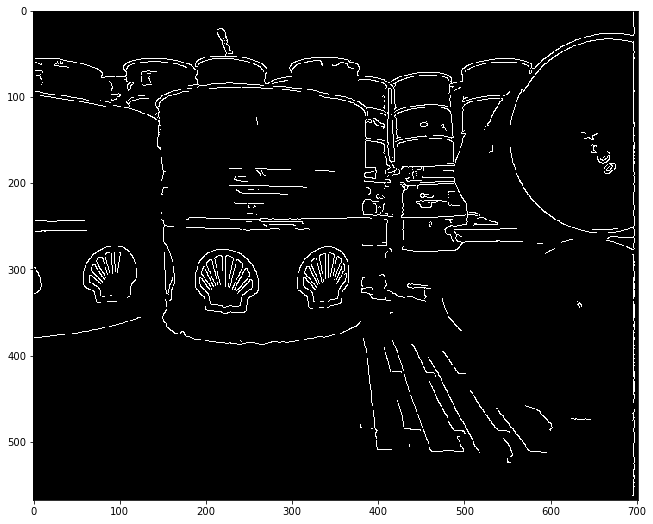

In [138]:
image = open_image(jj('data', 'evaluation', '1.jpg'), color=False)
canny = Canny(image, 60, 120)
image = canny.get_features()
plt.figure(figsize=(12,9))
plt.imshow(image, cmap=plt.cm.gray)
plt.show()

## 3.2 HISTOGRAM OF ORIENTED GRADIENTS ALGORITHM

#### SECOND TRY TO CREATE FEAUTRES. PARTIALLY SUCCESSFULL.

In [339]:
from skimage.draw import line

class HOG(object):
    def __init__(self, win_size, block_size=16, block_stride=8, cell_size=8, nbins=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.nbins = nbins
        self.sobel_Gx_filter = np.asarray([[-1, 0, 1],
                                           [-2, 0, 2],
                                           [-1, 0, 1]], dtype=np.int)

        self.sobel_Gy_filter = np.asarray([[-1, -2, -1],
                                           [0, 0, 0],
                                           [1, 2, 1]], dtype=np.int)

        self.height, self.width = self.win_size

    def get_features(self, array):
        Gx = self.get_Gx(array)
        Gy = self.get_Gy(array)
        G = self.get_G(Gx, Gy)
        theta = self.get_theta(Gx, Gy)
        
        # Create histograms in cells
        normalized_theta =  theta / np.pi
        normalized_theta = np.where(normalized_theta > 0, normalized_theta, normalized_theta+1)
        b_step = 1.0/self.nbins
        b_bottom = normalized_theta // b_step
        b_bottom[b_bottom>=self.nbins] = 0
        b_top = b_bottom + 1
        b_top[b_top>=self.nbins] = 0
        b_delta = (normalized_theta % b_step) / b_step
        coefs = np.zeros((self.height, self.width, self.nbins))       
        for i in range(self.nbins):
            coefs[:,:,i] += np.where(b_bottom==i,(1-b_delta),0)
            coefs[:,:,i] += np.where(b_top==i, b_delta, 0)
            
        bins = np.zeros(coefs.shape, dtype=np.int)
        for row in range(coefs.shape[0]):
            for col in range(coefs.shape[1]):
                bins[row][col] = coefs[row][col] * G[row][col]   
        
        histograms = []
        for row in range(0, int(self.height / self.cell_size)):
            for col in range(0, int(self.width / self.cell_size)):
                hist = bins[row * self.cell_size: row * self.cell_size + self.cell_size,
                            col * self.cell_size: col * self.cell_size + self.cell_size,:].sum(axis=0).sum(axis=0)
                histograms.append(hist)
        histograms = np.array(histograms).reshape((int(self.height / self.cell_size), int(self.width / self.cell_size), self.nbins))
        
        # Normalize in blocks
        features = []
        for row in range(0, histograms.shape[0], int(self.block_stride/self.cell_size)):
            for col in range(0, histograms.shape[1], int(self.block_stride/self.cell_size)):
                hist = histograms[row: row + int(self.block_size / self.cell_size),
                                  col: col + int(self.block_size / self.cell_size)]

                if hist.shape == (int(self.block_size / self.cell_size), int(self.block_size / self.cell_size), self.nbins):
                    features.append(normalize(hist.ravel()))
                    
        return self.get_gradients_image(histograms), np.asarray(features, dtype=np.float32).ravel().reshape(-1, 1)        
    
    def get_gradients_image(self, histograms):
        "Get direction of gradient with the biggest magnitude in each cell"
        result = np.zeros((self.height, self.width), dtype=np.int)
        global_max_magnitude = np.max(histograms)
        for row in range(0, int(result.shape[0]/self.cell_size)):
            for col in range(0, int(result.shape[1]/self.cell_size)):
                for direction, magnitude in enumerate(histograms[row][col]):           
                    if direction == 0:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(1, 4, 6, 4)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 1:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(6, 2, 1, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 2:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(6, 1, 1, 5)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 3:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(5, 1, 1, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 4:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(4, 1, 4, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 5:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(2, 1, 5, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 6:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(1, 1, 6, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 7:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(1, 2, 6, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 8:
                        line_array = np.zeros((8, 8), dtype=np.uint8)                    
                        line_array[line(1, 3, 6, 4)] = int(magnitude*255/global_max_magnitude)

                    result[row * self.cell_size: row * self.cell_size + self.cell_size,
                           col * self.cell_size: col * self.cell_size + self.cell_size] += line_array
                
        return result
    
    def get_Gx(self, array):
        zero_padded_array = np.pad(array, 1, mode='constant')
        return self.convolve(zero_padded_array, self.sobel_Gx_filter)

    def get_Gy(self, array):
        zero_padded_array = np.pad(array, 1, mode='constant')
        return self.convolve(zero_padded_array, self.sobel_Gy_filter)

    def get_G(self, Gx, Gy):
        return np.sqrt(np.square(Gx) + np.square(Gy))

    def get_theta(self, Gx, Gy):
        """Result is in radians from -π to π"""
        return np.arctan2(Gy, Gx)

    def convolve(self, array, filter_array):
        result_array = np.zeros((self.height, self.width), dtype=np.int)
        offset = filter_array.shape[0] // 2
        for row in range(self.height):
            for col in range(self.width):
                if (self.height - 2 * offset >= row >= offset) and (self.width - 2 * offset >= col >= offset):
                    new_value = 0
                    for f_row in range(filter_array.shape[0]):
                        for f_col in range(filter_array.shape[1]):
                            new_value += array[row - offset + f_row][col - offset + f_col] * filter_array[f_row][f_col]
                    result_array[row - offset, col - offset] = new_value
        return result_array

#### CREATE INSTANCE OF HOG MODEL.

In [340]:
winSize = (64, 64)
blockSize = 16
blockStride = 8
cellSize = 8
nbins = 9

my_hog = HOG(winSize,blockSize,blockStride,cellSize,nbins)

#### USE SKIMAGE LIBRARY TO VISUALIZE HOG ALGIRTHM ON SAMPLE IMAGE.

/home/maciejpesko/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


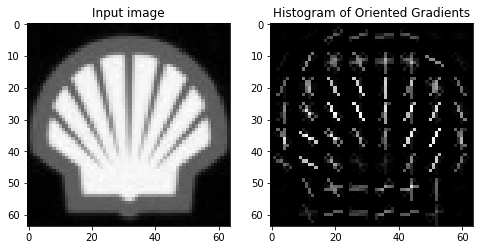

In [317]:
from skimage.feature import hog
from skimage import data, exposure

image = open_image(jj('data', 'logo_64', 'logo0.jpg'), color=False)
# image = hitogram_equalization(image)
fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualise=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

#### PLOT GRADIENT DIRECTIONS ON THE SAME IMAGE USING IMPLEMENTED HOG ALGORITHM. MATRIX SHOWS DIRECTIONS OF GRADIENTS WITH THE BIGGEST MAGNITUDE IN EACH CELL.

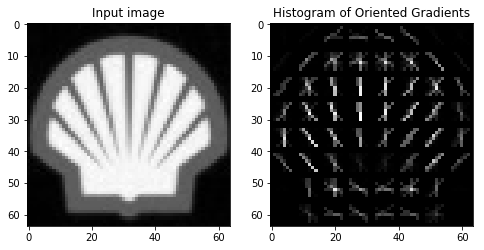

In [346]:
image = open_image(jj('data', 'logo_64', 'logo0.jpg'), color=False)

# image = hitogram_equalization(image)
grad, hist = my_hog.get_features(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.imshow(grad, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

#### FOR FURTHER COMPUTATIONS THERE WILL BE USED OPENCV2 HOG ALGORITHM BECAUSE OF THE VERY FAST PERFORMANCE WHICH IS NEEDED TO COMPUTE FEATURES DURING WINDOWS SLIDING ON FINAL IMAGES.

In [217]:
winSize = (64,64)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

winStride = (8,8)
padding = (8,8)
locations = ((0,0),)

## 4. Prepare Dataset

#### FUNCTION USED TO GENERATE 16 000 OF  SHELL LOGOS THAT DIFFER IN ASPECTS LIKE POSITION, ROTATION, SIZE.

In [80]:
# generate_logos()

#### SCRIPTS USED TO RESIZE DEFAULT LOGO AND OTHER IMAGES TO PROPER SIZES. OTHER OBJECTS ARE TAKEN FROM CALTECH-256 DATASET: http://www.vision.caltech.edu/Image_Datasets/Caltech256/

In [81]:
# # Create 64x64 images of logos
# for image_name in os.listdir(LOGO):
#     img = open_image(jj(LOGO, image_name))
#     img = resize(img, IMG_SIZE, IMG_SIZE)
#     cv2.imwrite(jj(LOGO_64, image_name), img)      

In [82]:
# # Create 64x64 images of other objects
# for image_name in os.listdir(OTHER):
#     img = open_image(jj(OTHER, image_name))
#     img = resize(img, IMG_SIZE, IMG_SIZE)
#     cv2.imwrite(jj(OTHER_64, image_name), img)  

#### SCRIPTS USED TO OBTAIN HOG FEATURES FROM IMAGES, BUILD DATASET AND SAVE IT.

In [83]:
# # Get HOG features of all logo images
# logos = []
# for i in tqdm(range(NUMBER_OF_LOGOS)):
#     img = open_image(jj(LOGO_64, 'logo{}.jpg'.format(i)), color=False)
# #     img = hitogram_equalization(img)
# #     img = resize(img, IMG_SIZE)
#     logo_hist = hog.compute(img,winStride,padding,locations)
# #     logo_hist = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualise=True)
# #     logo_hist = my_hog.get_features(img)
#     logos.append((logo_hist, 1))

In [84]:
# # Get HOG features of all other images
# others = []
# for i in tqdm(range(NUMBER_OF_OTHERS)):
#     img = open_image(jj(OTHER_64, 'other{}.jpg'.format(i)), color=False)
# #     img = hitogram_equalization(img)
# #     img = resize(img, IMG_SIZE)
#     other_hist = hog.compute(img,winStride,padding,locations)
# #     other_hist = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualise=True)
# #     other_hist = my_hog.get_features(img)
#     others.append((other_hist, 0))

In [85]:
# # Build dataset
# dataset = logos + others
# random.shuffle(dataset)
# print(len(dataset))


#### SCRIPT FOR SPLIT DATASET TO TRAINING AND VALIDATION  DATASET AND TEST DATASET AND EXPORT DATA.

In [86]:
# train_and_validation, test = split_data(dataset, train_size=0.9)

In [87]:
# export train_and_validation and test dataset
# pickle.dump( train_and_validation, open(os.path.join("data", "train_and_validation_dataset.data"), "wb" ))
# pickle.dump( test, open(os.path.join("data", "test_dataset.data"), "wb" ))

#### SPLIT ON X AND Y AND CONVERT TO NUMPY ARRAY.

In [88]:
x_train_and_validationn = np.asarray([i[0] for i in train_and_validation])
y_train_and_validation = np.asarray([i[1] for i in train_and_validation])

x_test = np.asarray([i[0] for i in test])
y_test = np.asarray([i[1] for i in test])

# x_train_and_validation = x_train.reshape((x_train_and_validation.shape[0], x_train_and_validation.shape[1]))
# x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]))

## 5. Create and evaluate SVM model

#### CREATE SVM MODEL USING OPENCV. 

In [89]:
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(1)
svm.setGamma(1)

#### EVALUATE ON VALIDATION DATASET USING K_FOLD VALIDATION.

In [90]:
k_fold_split_array = k_fold_split_data(train_and_validation, 10)
train_accuracies = []
validation_accuracies = []

for n, validation in enumerate(k_fold_split_array):
    train = k_fold_split_array.copy()
    train.pop(n)
    train = np.concatenate(train)

    x_train = np.asarray([i[0] for i in train])
    y_train = np.asarray([i[1] for i in train])

    x_validation = np.asarray([i[0] for i in validation])
    y_validation = np.asarray([i[1] for i in validation])

    svm.train(x_train, cv2.ml.ROW_SAMPLE, y_train)
    
    y_pred = svm.predict(x_train)[1]
    train_accuracies.append(accuracy_score(y_train, y_pred))
    
    y_pred = svm.predict(x_validation)[1]
    validation_accuracies.append(accuracy_score(y_validation, y_pred))

print("Training accuracy: {}".format(np.average(train_accuracies)))
print("Validation accuracy: {}".format(np.average(validation_accuracies)))

Training accuracy: 1.0
Validation accuracy: 1.0


#### EVALUATE ON TEST DATASET.

In [91]:
# Evaluate model on test dataset
y_pred = svm.predict(x_test)[1]
accuracy_score(y_test, y_pred)

1.0

#### PLOT CONFUSION MATRIX FOR DATASET.

In [92]:
plot_confusion_matrix(svm, x_test, y_test)


Precision: 1.0
Recall: 1.0
F-score: 1.0


             actual 1  actual 0
predicted 1       732         0
predicted 0         0       768


#### PLOT ROC CURVE (RECEIVER OPERATING CHARACTERISTIC.

100%|██████████| 21/21 [00:00<00:00, 501.16it/s]
/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


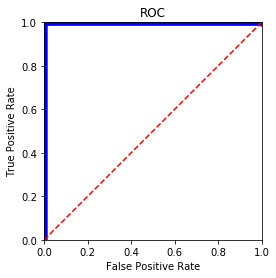

In [93]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    normalized_svm_raw_results = -1*(normalize(svm.predict(x_test, flags=1)[1]) - 1)
    predicted = np.round(normalized_svm_raw_results + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)

## 6. Find Shell logo on images

#### FUNCTION TO SLIDE 64X64 WINDOW OVER DIFFERENT, SCALED IMAGE SIZES TO FIND WANTED LOGO.

In [94]:
def get_bboxes(path, stride):
    image = open_image(path, color=False)
#     image = hitogram_equalization(image)
    global_height, global_width = image.shape

    ratio = global_height/global_width

    results = []
    for i in tqdm(range(1, int(min(global_height, global_width)/IMG_SIZE)+4)):
        img = resize(image, i * IMG_SIZE, int(i * IMG_SIZE*ratio))
        height, width = img.shape

        r_h = global_height / height
        r_w = global_width / width

        for row in range(0, height, stride):
            for col in range(0, width, stride):
                up, bottom, left, right = row, row + IMG_SIZE, col, col + IMG_SIZE
                window = img[up:bottom, left:right]

                if window.shape == (IMG_SIZE, IMG_SIZE):
                    hist = hog.compute(window,winStride,padding,locations).reshape((1, -1))
#                     hist = my_hog.get_features(window).reshape((1, -1))
                    prediction = svm.predict(hist)

                    if prediction[1][0][0] == 1:
                        up_abs = int(up*r_h)
                        bottom_abs = int(bottom*r_h)
                        left_abs = int(left*r_w)
                        right_abs = int(right*r_w)
                        results.append((up_abs, bottom_abs, left_abs, right_abs))
    return results


#### FUNCTION TO JOIN OVERLAPPING BOUNDING BOXES.

In [95]:
def join_bboxes(bboxes):
    results = []
    sorted_bboxes = sorted(bboxes, key=lambda x: x[0]+x[2])

    while len(sorted_bboxes) > 0:
        temp_up, temp_bottom, temp_left, temp_right = sorted_bboxes[0]
        for num, (up, bottom, left, right) in enumerate(sorted_bboxes[1:]):
            if ((temp_up <= up <= temp_bottom) or (temp_up <= bottom <= temp_bottom)) and ((temp_left <= left <= temp_right) or (temp_left <= right <= temp_right)):
                if up <= temp_up:
                    temp_up = up
                if bottom >= temp_bottom:
                    temp_bottom = bottom
                if left <= temp_left:
                    temp_left = left
                if right >= temp_right:
                    temp_right = right
                sorted_bboxes.remove((up, bottom, left, right))
        results.append((temp_up, temp_bottom, temp_left, temp_right))
        sorted_bboxes.pop(0)
    return results


#### FUNCTION TO PLOT BOUNDING BOX AROUND FOUND SHELL LOGOS.

In [96]:
def plot_results(path, bboxes):
    image = open_image(path)
    for up, bottom, left, right in bboxes:                
        for row in range(image.shape[0]):
            for col in range(image.shape[1]):
                if (row == up or row == bottom) and right >= col >= left:
                    try:
                        image[row][col] = 0, 255, 0
                        image[row+1][col] = 0, 255, 0
                        image[row-1][col] = 0, 255, 0
                    except IndexError:
                        continue

                if (col == right or col == left) and bottom >= row >= up:
                    try:
                        image[row][col] = 0, 255, 0
                        image[row][col+1] = 0, 255, 0
                        image[row][col-1] = 0, 255, 0
                    except IndexError:
                        continue

    plt.figure(figsize=(12,10))
    plt.imshow(image[:,:,[2,1,0]])
    plt.show()
    return image

#### SCRIPT FOR FINDING LOGOS IN THE EVALUTION PICTURES.

100%|██████████| 11/11 [00:03<00:00,  3.60it/s]


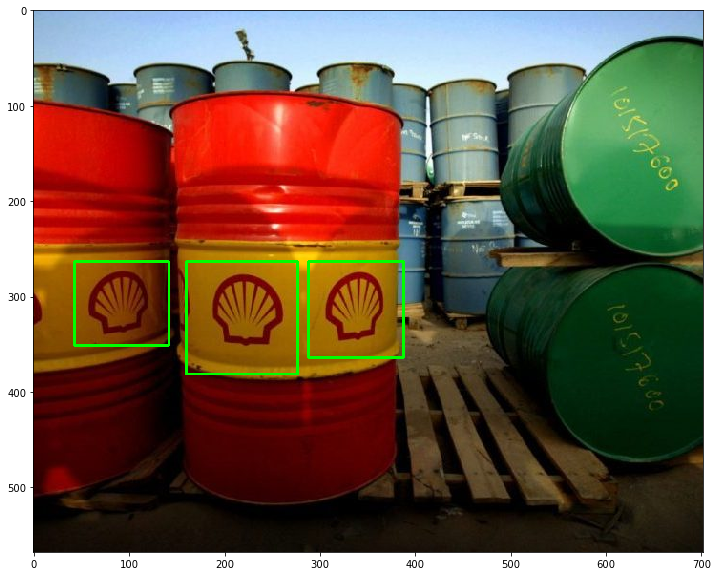

100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


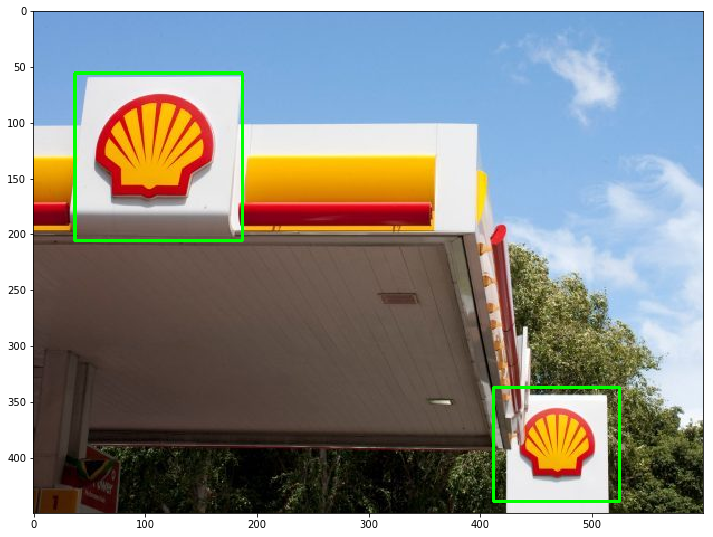

100%|██████████| 12/12 [00:03<00:00,  3.52it/s]


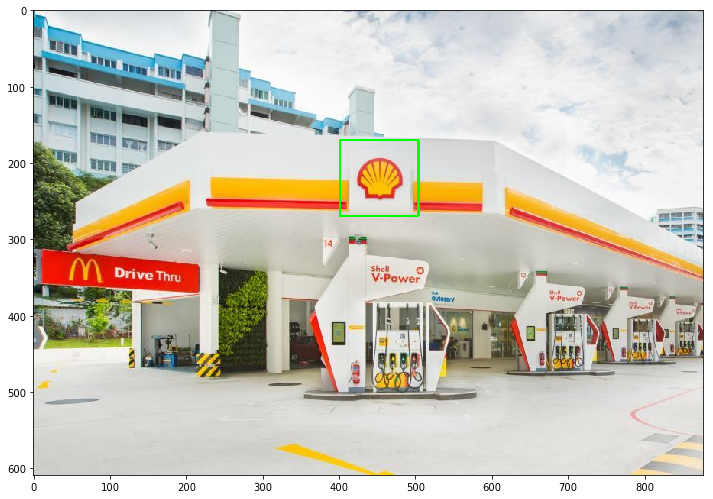

100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


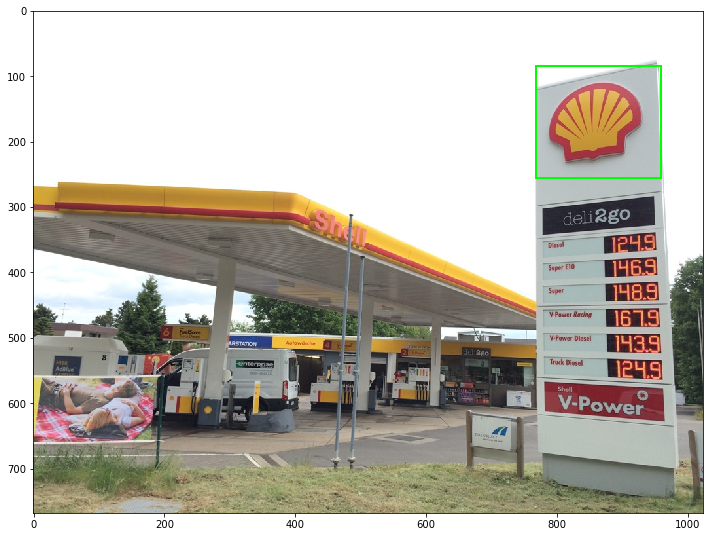

100%|██████████| 12/12 [00:03<00:00,  3.91it/s]


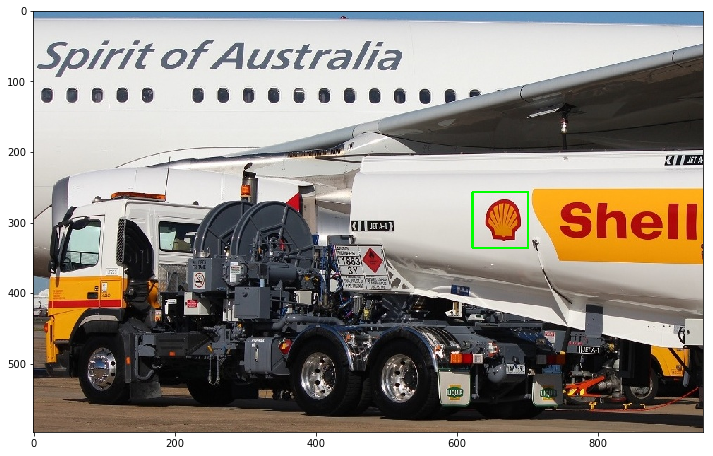

100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


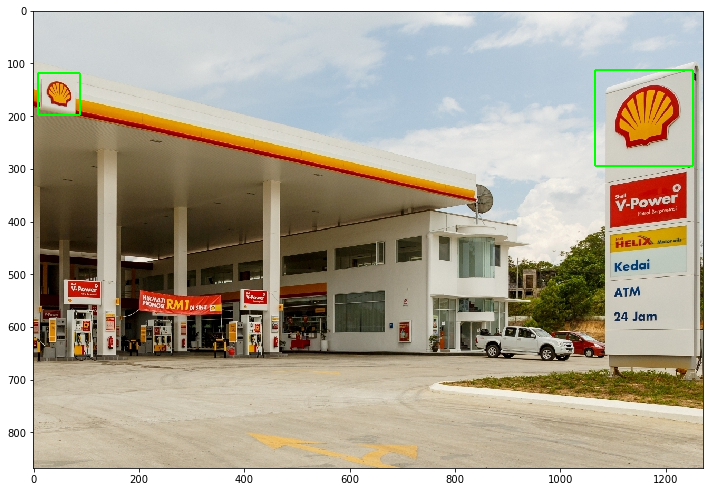

In [97]:
for i in range(1, 7):
    path = jj('data', 'evaluation', '{}.jpg'.format(i))
    bboxes = get_bboxes(path, 8)
    joined_bboxes = join_bboxes(bboxes)
    image = plot_results(path, joined_bboxes)
    cv2.imwrite(jj('data', 'evaluation', 'result_{}.jpg'.format(i)), image)
    